In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/PAC/cnn
#%cd ..

/content/drive/MyDrive/Github/PAC/cnn


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats, signal, ndimage as nd
from skimage.transform import rotate
from src import data
from src import visualize as vs

In [4]:
jpg_files = np.array(list(data.Paths.DATA.glob('**/*.jpg')))
num_samples = len(jpg_files)
images = np.squeeze(data.load_collection(jpg_files, grayscale=True).numpy())
labels = np.squeeze(data.load_collection(map(lambda file: file.with_suffix('.png'), jpg_files), grayscale=True).numpy()/255)
areas = np.stack(list(map(lambda file: float(file.stem), jpg_files)))
scale_true = areas/labels.sum(axis=(1, 2))
images.shape, labels.shape, scale_true.shape

((63, 256, 256), (63, 256, 256), (63,))

In [6]:
def FFT(x):
    return np.abs(np.fft.fft(x))

def FFT2(x):
    return np.abs(np.fft.fftshift(np.fft.fft2(x)))

def Cxx(x, mode='same'):
    return np.correlate(x, x, mode=mode)

def PSD(x):
    return FFT(Cxx(x))

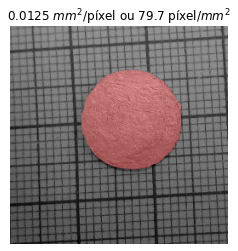

In [7]:
i = np.random.randint(num_samples) #[areas == 20.623][0]
img = images[i]
I, G, St = images[i], labels[i], scale_true[i]

vs.plot_label(I, G)
plt.title(r'{:.4f} $mm^2$/píxel ou {:.1f} píxel/$mm^2$'.format(St, 1/St))
plt.show()

In [8]:
freqs = np.fft.fftfreq(I.shape[1])
pos = freqs > 0
freqs.shape

(256,)

# Detecção da escala

## Métodologia

In [9]:
def plot_on(axs, xy, *args, **kwargs):
    for ax, (x, y) in zip(axs, xy):
        ax.plot(x, y, *args, **kwargs)

def plot_step(inpt, func):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))

    pattern = np.random.randint(0, inpt.shape[0], 20)
    plot_on(axs.flat, [
        [range(inpt.shape[1]), inpt[pattern].T],
        [freqs[pos], np.apply_along_axis(lambda x: func(x)[pos], 1, inpt[pattern]).T]
    ], 'C0-', alpha=0.2)

    axs[1].vlines(np.sqrt(St), *axs[1].get_ylim(), color='r', lw=3, ls='dashed', label=r'$\xi_{true}$')
    axs[1].legend(fontsize=14)

    axs[1].set_xlabel(r'$\xi$ (p$^{-1}$)')
    fig.tight_layout()
    plt.show()

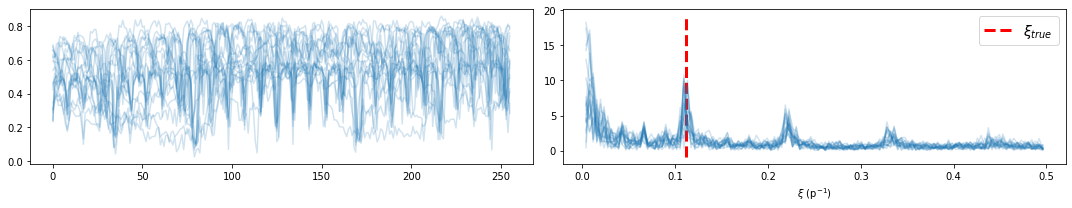

In [10]:
plot_step(I, FFT)

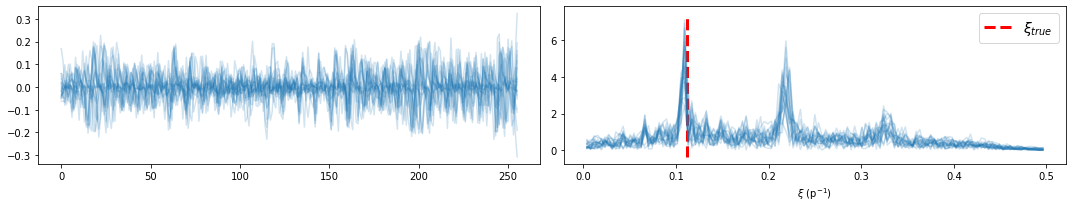

In [11]:
Ix = np.gradient(I)[0].T
plot_step(Ix, FFT)

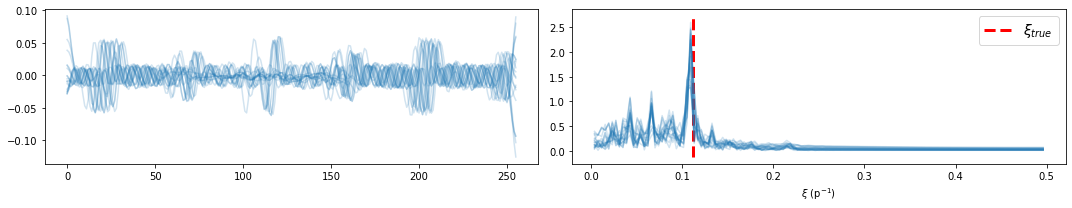

In [12]:
Ix_gauss = nd.gaussian_filter(Ix, 2)
plot_step(Ix_gauss, FFT)

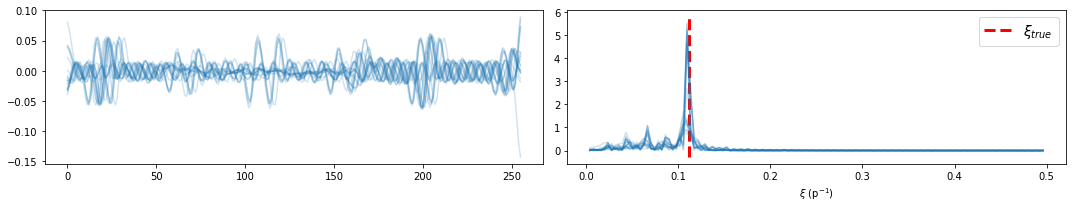

In [13]:
plot_step(Ix_gauss, PSD)

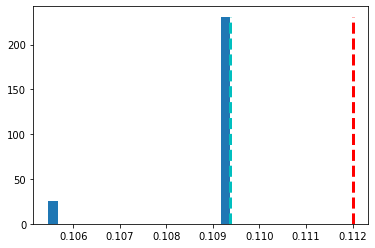

In [25]:
D = np.apply_along_axis(lambda y: np.abs(freqs[np.argmax(FFT(y))]), 1, Ix_gauss)
h, _, _ = plt.hist(D, bins=20)
plt.vlines(np.sqrt(St), 0, h.max(), color='r', lw=3, ls='dashed', label=r'$\xi_{true}$')
plt.vlines(stats.mode(D).mode[0], 0, h.max(), color='c', lw=3, ls='dashed', label=r'$\xi_{true}$')
plt.show()

## Implementação e testes

In [30]:
def find_scale(img, sigma=2, method='mean'):
    Iy, Ix = np.gradient(img)
    fs, stds = [], []
    for dI in (Ix, Iy.T):
        freqs = np.fft.fftfreq(dI.shape[1], 1)
        pos = freqs > 0
        dI_gauss = nd.gaussian_filter(dI, sigma)
        D = np.apply_along_axis(lambda y: freqs[pos][np.argmax(PSD(y)[pos])], 1, dI_gauss)

        if method == 'mean':
            fs.append(D.mean())
            stds.append(D.std())
        elif method == 'mode':
            fs.append(stats.mode(D).mode[0])
            stds.append(0.5/256)

    (fx, fy), (dx, dy) = fs, stds
    return fx*fy, np.sqrt((dx*fy)**2 + (dy*fx)**2)

In [31]:
gaussian_scale = np.arange(0, 10, 0.25)
out = {}
for method in ('mean', 'mode'):
    try: 
        %time out[method] = np.stack([[find_scale(image, sigma=sigma, method=method) for image in images] for sigma in gaussian_scale])
    except Exception as error: print(error)

CPU times: user 1min 18s, sys: 150 ms, total: 1min 18s
Wall time: 1min 20s
CPU times: user 1min 24s, sys: 202 ms, total: 1min 24s
Wall time: 1min 29s


1.75 4.949629986761819
2.0 2.2185189774468745


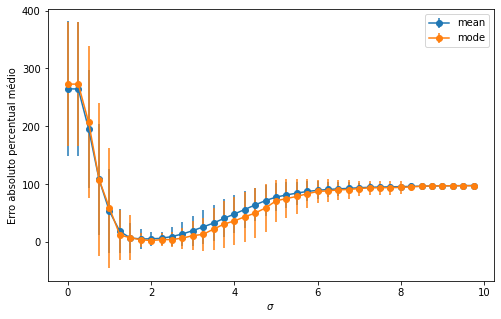

In [32]:
def mape(y_true, y_pred):
    return np.abs(y_true-y_pred)/y_true * 100

plt.figure(figsize=(8, 5))
for method, pred in out.items():
    error = mape(scale_true, pred[:, :, 0])
    plt.errorbar(gaussian_scale, error.mean(axis=1), error.std(axis=1), fmt='-o', label=method)
    min_error = np.argmin(error.mean(axis=1))
    print(gaussian_scale[min_error], error[min_error].mean())

plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel('Erro absoluto percentual médio')
plt.show()

CPU times: user 1.75 s, sys: 2.92 ms, total: 1.76 s
Wall time: 1.78 s


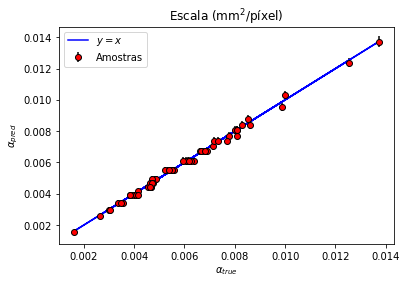

In [33]:
%time scale_pred = np.stack([find_scale(image, sigma=2, method='mode') for image in images])
plt.errorbar(scale_true, scale_pred[:, 0], scale_pred[:, 1], fmt='o', markeredgecolor='k', markerfacecolor='r', color='k', label='Amostras')
plt.plot(scale_true, scale_true, 'b-', label='$y=x$')
plt.legend()
plt.title(r'Escala (mm$^2$/píxel)')
plt.xlabel(r'$\alpha_{true}$')
plt.ylabel(r'$\alpha_{pred}$')
plt.show()

In [34]:
rel_error = (scale_true - scale_pred[:, 0])/scale_true*100
stats.describe(rel_error)

DescribeResult(nobs=63, minmax=(-5.377973106504527, 5.804372033803283), mean=0.4727773241780217, variance=7.415340183257765, skewness=0.13941820343338757, kurtosis=-0.6208288243133877)

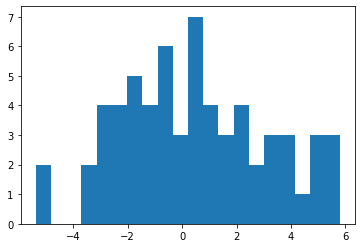

In [35]:
plt.hist(rel_error, bins=20)
plt.show()

In [36]:
i = np.random.randint(num_samples)
alpha, d_alpha = scale_pred[i]
parea = labels[i].sum()

print('Escala detectada:', '(%s +- %s) píxels/mm^2'%(1/alpha, d_alpha/alpha**2))
print('Area verdadeira:', areas[i])
print('Area estimada:', '(%s +- %s) mm^2'%(parea*alpha, parea*d_alpha))

Escala detectada: (163.84 +- 5.792618751480197) píxels/mm^2
Area verdadeira: 134.043
Area estimada: (130.6640625 +- 4.619672232556644) mm^2


## Modelo tensorflow

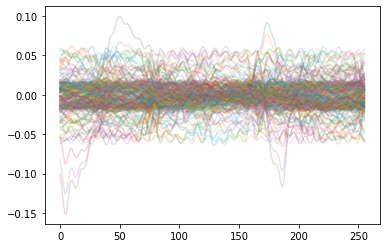

In [24]:
def tf_Cxx(x):
    td = tf.pad()
    tf.nn.conv1d(x, x, strides=1, padding='SAME')

plt.plot(Ix_gauss, alpha=0.2)
plt.show()

In [ ]:
class ScaleDetector(tf.keras.Model):
    def __init__(self, sigma):
        super().__init__(trainable=False, name='ScaleDetector')
        self.sigma = sigma

    def build(self, input_shape): pass
    
    def call(self): pass

# Detecção da inclinação

In [37]:
angle = 15

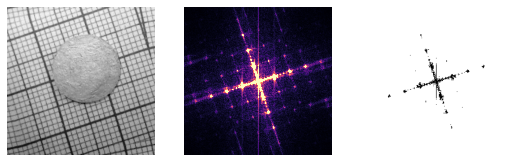

In [40]:
T3 = 2.5e-3

fig = plt.figure(figsize=(9, 3))

I = rotate(img, angle, mode='reflect')
fft2d = FFT2(I)
L = fft2d > fft2d.max()*T3

fig.add_subplot(131)
vs.plot_image(I, cmap='gray')

fig.add_subplot(132)
vs.plot_image(fft2d, cmap='magma', vmax=fft2d.max()*T3)

fig.add_subplot(133)
vs.plot_image(L, cmap='binary')

plt.show()

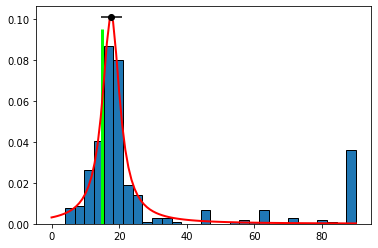

Predição: 17.60454738933354 +- 3.1146393106711754
Erro: 17.36%


In [41]:
X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90

h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k')

local, scale = stats.cauchy.fit(H)
cauchy = stats.cauchy(local, scale)
x = np.linspace(0, 90, 100)
f = cauchy.pdf(x)
plt.plot(x, f, 'r', lw=2)

angle_pred = local
angle_std = scale

plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
plt.errorbar(angle_pred, f[np.argmax(f)], xerr=angle_std, marker='o', c='k', zorder=4)

plt.show()
print(
    'Predição: %s +- %s'%(angle_pred, angle_std),
    f'Erro: {(np.abs(angle - angle_pred)/angle*100):.2f}%',
    sep='\n'
)

In [42]:
def find_slope(img, t=25e-4):
    fft2d = FFT2(img)
    L = fft2d > fft2d.max()*t
    X, Y = np.meshgrid(
        np.fft.fftshift(np.fft.fftfreq(img.shape[1], 1)),
        np.fft.fftshift(np.fft.fftfreq(img.shape[0], 1))
    )
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    return stats.cauchy.fit(H)

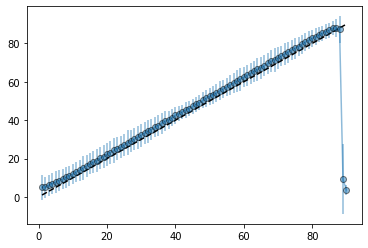

In [43]:
At = np.arange(1, 91)
A = np.stack([find_slope(rotate(img, a, mode='constant')) for a in At])

fig, ax = plt.subplots()
ax.errorbar(At, A[:, 0], A[:, 1], alpha=0.5, marker='o', markeredgecolor='k')
ax.plot(At, At, 'k--')
#ax.set_aspect('equal')
plt.show()

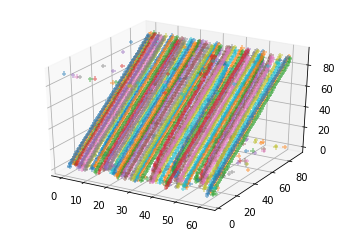

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

At = np.arange(1, 91)
E = []
for i in range(num_samples):
    A = np.stack([find_slope(rotate(images[i], a, mode='reflect')) for a in At])
    e = np.abs(At-A[:, 0])/At*100
    ax.scatter(np.full(At.shape, i), A[:, 0], At, marker='+', alpha=0.5)
    E.append(e.mean())
#plt.plot(E, 'r-')
plt.show()

In [ ]:
!pip install celluloid

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter
from celluloid import Camera

In [ ]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xlabel('inclinação')
fig.tight_layout()

camera = Camera(fig)
for angle in range(90):
    I = rotate(img, angle, mode='reflect')
    fft2d = np.abs(np.fft.fftshift(np.fft.fft2(I)))
    L = fft2d > fft2d.max()*25e-4
    X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    
    ax1.imshow(I, cmap='gray')
    ax2.imshow(fft2d, cmap='magma', vmax=fft2d.max()*25e-4)

    h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k', alpha=0.7, color='C0')
    x = np.linspace(H.min(), H.max(), 100)
    x0, scale = stats.cauchy.fit(H)
    f = stats.cauchy.pdf(x, x0, scale)

    plt.plot(x, f, 'C3-', lw=3)
    plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
    plt.errorbar(x0, f[np.argmax(f)], xerr=scale, marker='o', c='k', zorder=4)

    camera.snap()

animation = camera.animate()
animation.save('reports/figures/slope_detection.gif', writer=PillowWriter(fps=10))
plt.close()

![](../reports/figures/slope_detection.gif)